<a href="https://colab.research.google.com/github/NicoleMeinie/Regression/blob/master/Frankenstein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sendy Logistics Challenge
Logistics is fundamental to the success of a business.

It is reported that in Africa, logistics add an average of 320% to a manufactured good’s cost. Sendy is a logistics platform servicing East Africa and aims to help businesses and enterprises grow through efficient and affordable logistics.

Sendy is trying to predict accurate arrival times that will assist businesses in improving logistic operations and communicate accurate times to customers awaiting deliveries. Data is key in this endeavour and this project aims to use the given data to build a model to make these arrival time predictions. practical solutions for Africa’s dynamic transportation needs.

The training dataset provided here is a subset of over 20,000 orders and only includes direct orders (i.e. Sendy “express” orders) with bikes in Nairobi. All data in this subset have been fully anonymized while preserving the distribution.

# Import Libraries and datasets

In [0]:
# Import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# machine learning 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Three .csv files were provided: "Train.csv", "Test.csv" & "Riders.csv". Let's import these datasets.

In [0]:
# import each csv file
test_raw = pd.read_csv('Test.csv')
train_raw = pd.read_csv('Train.csv')
riders_raw = pd.read_csv('Riders.csv')
Sub = pd.read_csv('SampleSubmission.csv')

# Join riders to test & train data and initialise working dataframes
Train = train_raw.merge(riders_raw, how="left", on = "Rider Id") 
Test = test_raw.merge(riders_raw, how="left", on = "Rider Id")

Great! Let's build a model!

#Exploratory Data Analysis
Hold on! Exploratory Data Analysis is vital in determining our data structure; potential patterns & relationships between the variables in the dataset and ascertaining whether our dataset is in the best format for processing by the model we'll eventually be building. We've divided EDA into the following sections: Completeness, Data Types & Initial Variable Selection & Visualisation. Once we have 'the lay of the land' we'll move on to Preprocessing the datasets.

##Completeness of the Data

Quality of a dataset is dependent on completeness. Let's investigate which variables have those pesky null values and figure out a way forward to handle them.

In [20]:
train_raw.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [21]:
test_raw.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [22]:
riders_raw.head()

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156


In [23]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [24]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              7068 non-null   object 
 1   User Id                               7068 non-null   object 
 2   Vehicle Type                          7068 non-null   object 
 3   Platform Type                         7068 non-null   int64  
 4   Personal or Business                  7068 non-null   object 
 5   Placement - Day of Month              7068 non-null   int64  
 6   Placement - Weekday (Mo = 1)          7068 non-null   int64  
 7   Placement - Time                      7068 non-null   object 
 8   Confirmation - Day of Month           7068 non-null   int64  
 9   Confirmation - Weekday (Mo = 1)       7068 non-null   int64  
 10  Confirmation - Time                   7068 non-null   object 
 11  Arrival at Pickup

In [25]:
riders_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rider Id        960 non-null    object 
 1   No_Of_Orders    960 non-null    int64  
 2   Age             960 non-null    int64  
 3   Average_Rating  960 non-null    float64
 4   No_of_Ratings   960 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 37.6+ KB


**Observations:**

*  Both the train & test data sets have missing values for the 'Temperature' & 'Precipitation' columns. The values for the train data should be imputed using an appropriate method after the Train-Validation Split. Approximately 20% of the Temperature values are missing in both the Test & Train data sets. Replacing the NaN with the average would therefore be a reasonable assumption. Approximately 97% of the Precipitation values are missing. Imputation of the NaN values could be achieved either via assuming zero precipitation for those Order times, or imputation by mode.


*  As the data has already been split into training & test sets we can go ahead and imput the values for each set. It's best practice to impute values after the split to ensure a fair test of the model evetually built.


*  The riders.csv file has no missing values. Phew!


*  Side Note: The column names for the test and train data could do with some formatting to get rid of spaces between strings, but perhaps we'll leave this as is to match the submission file format.


*  The train data set has four additional columns centred arround the arrival time of the order: 'Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Time', 'Time from Pickup to Arrival'. Other than that the columns are identical. This is expected as if we had these columns present in the Test set, we wouldnt have a response variable to predict!

*  It appears that the riders data could be joined with both the train and test data sets on the column 'Rider Id'. It is anticipated that some variables in this data set such as 'AverageRating' could be influential in predicting the response variable. What's that you say...? "all this does is increase the No. of variables in both sets!"... Yes, but there are definitely some variables that can be removed...

*  Summary - impute missing temperature and precipitation values. Join riders to both test & train.

##Distribution of the feature and response variables
A histogram of delivery times as well as the outlier threshold will be plotted to viuslize the distribution of the delivery times (response/target variable).

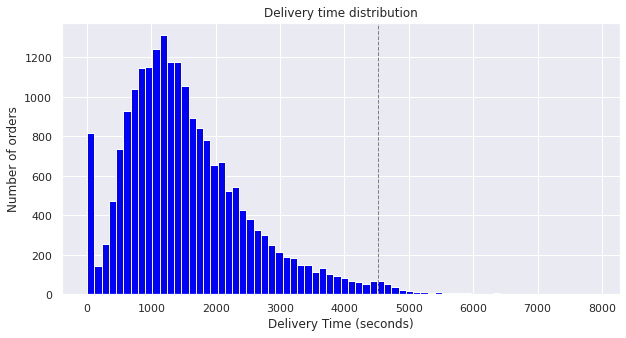

In [26]:
# Calculating the outlier threshold 
mu = Train['Time from Pickup to Arrival'].mean()
sd = Train['Time from Pickup to Arrival'].std()
li = mu + 3*sd

# creating the histogram - distribution of delivery times in seconds
sns.set()
_ = plt.figure(figsize = (10,5))
_ = plt.hist(Train['Time from Pickup to Arrival'], bins = 70, color = 'blue')
_ = plt.title('Delivery time distribution')
_ = plt.xlabel('Delivery Time (seconds)')
_ = plt.ylabel('Number of orders')
_ = plt.axvline(li, color = 'gray', linestyle = 'dashed', linewidth = 1)
plt.show()

**Observations:**

*   From the plot above it’s clear that the delivery times are possitively skewed, with the majority of orders being delivered in about 16 minutes 

*   There are orders with a delivery time of 1 second. These could be data points that weren't recorded properly. In practice these rows should be excluded when training the model.

* The grey dotted line above indicates the threshold for existance of outliers (measured by the presence of values 3 standard deviation away from the mean.) A small portion of the delivery times recorded with times > 4500 seconds can be considered outliers


## Distribution plots for all the features in the dataset

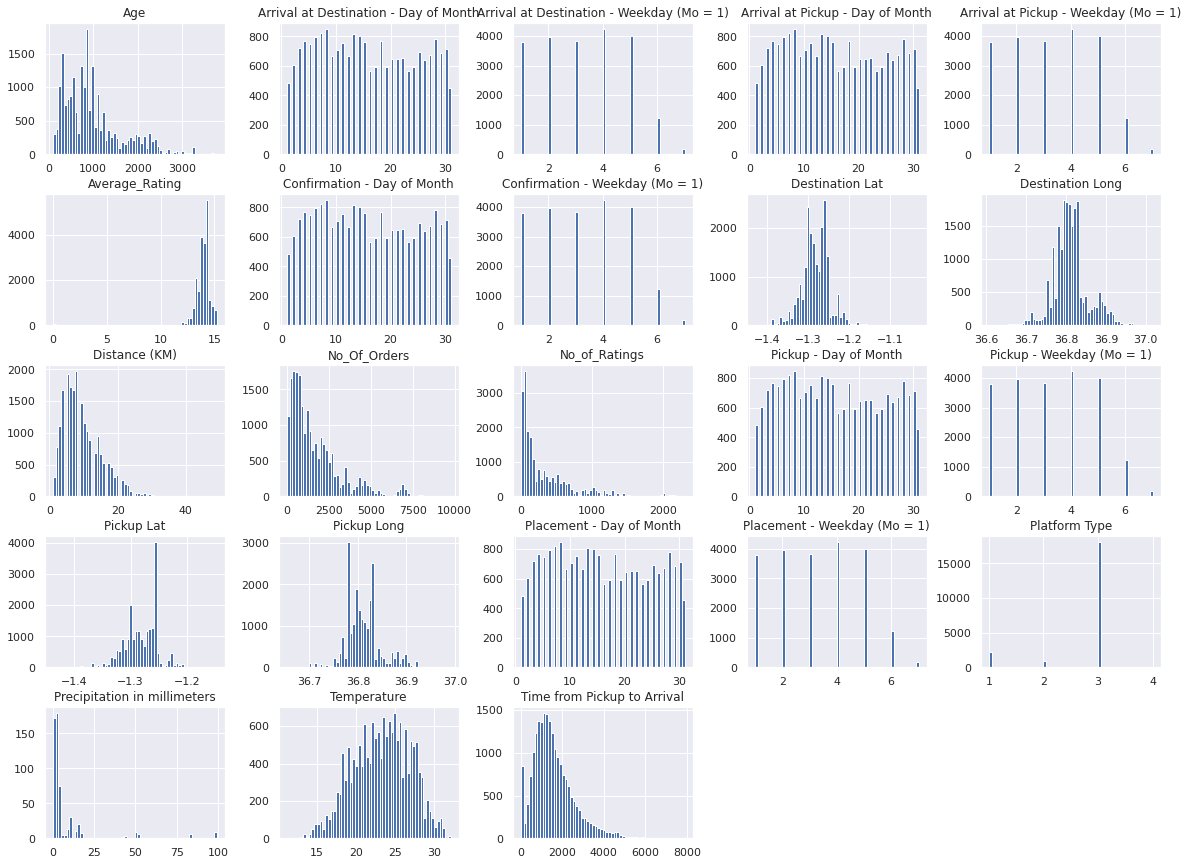

In [27]:
# creating a histogram for all the variables in the dataset to visulize the distribution of each feature
sns.set()
Train.hist(bins = 60, figsize = (20,15))
plt.show()

**Observations:**


*   Majority of the orders are placed using platform 3 and only a tiny portion using platform 4
*   Weekends are not as busy compared to weekdays 
* Most orders are delivered within a 10km radius
* Orders are spread out almost evenly across the day of the month - no obvious popular day
* Most Temperatures fall between 20 and 27 degrees celcius
* The average driver rating is between 13 and 15 with vary little varience 
* A large portion of riders have no or very few ratings

## Exploring the relationship between delivery time and a few features


### Day of the week

Next the relationship between the day of the week that orders are placed and the delivery times is visualized using a violin plot

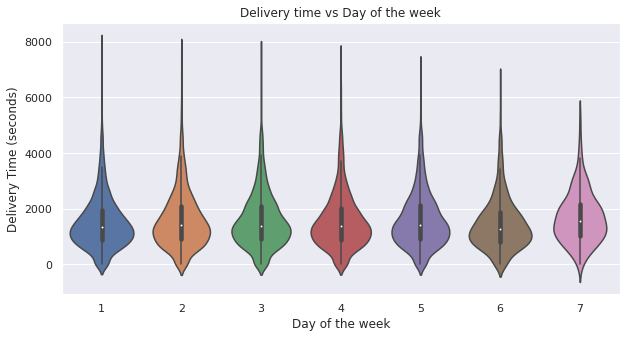

In [28]:
sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.violinplot(x = Train['Placement - Weekday (Mo = 1)'], y = Train['Time from Pickup to Arrival'], data = Train )
_ = plt.title('Delivery time vs Day of the week')
_ = plt.xlabel('Day of the week')
_ = plt.ylabel('Delivery Time (seconds)')

**Observations:**
 

*   Delivery times during the week have the same spread from monday to friday with slight differences in the extremity of outliers. 

* The delivery times during weekends have less variability and less extreme outliers. This could possibly be due to drivers experiencing less traffic over weekends 

### Type of client serviced
Sendy handles deliveries for businesses and personal clients. Does the type of client serviced have an effect on the delivery time?

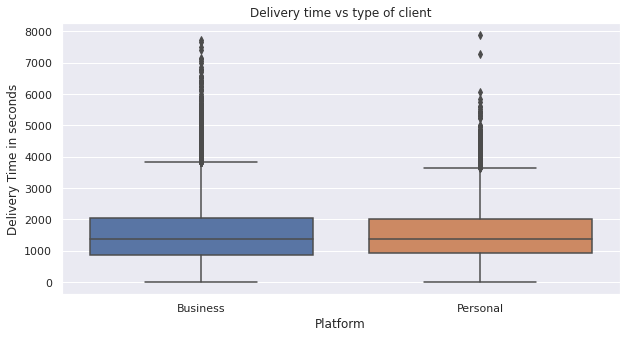

In [29]:
sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['Personal or Business'], y = Train['Time from Pickup to Arrival'], data = Train )
_ = plt.title('Delivery time vs type of client')
_ = plt.xlabel('Platform')
_ = plt.ylabel('Delivery Time in seconds')

**Observations:**

*  There is almost no difference in the distibution of delivery times for personal clients compared to businesses with the exception of a few outliers. 

### Platform used to place orders
Users can place orders using 4 different platforms. Is there a relationship between the type of platform used to place an order and the delievry time?

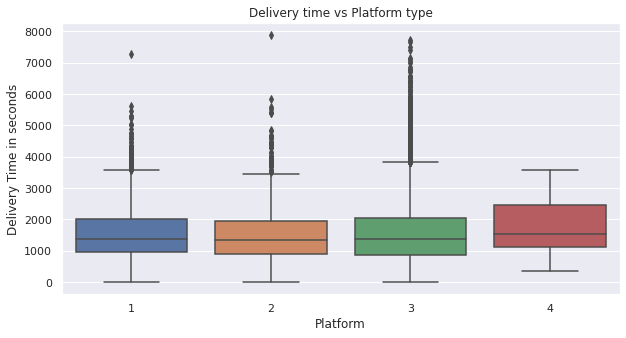

In [30]:
sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['Platform Type'], y = Train['Time from Pickup to Arrival'], data = Train )
_ = plt.title('Delivery time vs Platform type')
_ = plt.xlabel('Platform')
_ = plt.ylabel('Delivery Time in seconds')

**Observations:**

*  The delivery times for platform types 1 to 3 are similar, although more outliers are observed when orders are placed using platform 3.

*  Platform 4 